In [ ]:
import tensorflow as tf
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 3)).astype('float32') / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

length = train_images.shape[1]
width = train_images.shape[2]
channels = train_images.shape[3]

train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
class Sampling(tf.keras.layers.Layer):
    @tf.function
    def call(self, inputs, training=False):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def get_encoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    flatten = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(dense_units[0], activation='relu', kernel_regularizer='l2')(flatten)
    x = tf.keras.layers.BatchNormalization()(x)
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    model = tf.keras.Model(inputs, z, name="Encoder")
    return model

def get_decoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, stride_reduction):
    inputs = tf.keras.Input(shape=(latent_dim,))

    x = tf.keras.layers.Dense(dense_units[0], activation='relu', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(int(input_shape[0]*input_shape[1]*filters[3]/stride_reduction**2), activation='relu', kernel_regularizer='l2')(x)
    
    reshaped = tf.keras.layers.Reshape((int(input_shape[0]/stride_reduction), int(input_shape[1]/stride_reduction), filters[3]))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same', kernel_regularizer='l2')(reshaped)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same', kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same', kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same', kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    image = tf.keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=kernel_size[0], strides=1, padding='same', kernel_regularizer='l2')(x)

    model = tf.keras.Model(inputs, image, name="Decoder")
    return model

def get_discriminator(latent_dim, discriminator_units):
    inputs = tf.keras.Input(shape=(latent_dim,))

    x = tf.keras.layers.Dense(discriminator_units[0], activation='relu', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.Dense(discriminator_units[1], activation='relu', kernel_regularizer='l2')(x)

    vote = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, vote, name="Discriminator")
    return model


    

In [ ]:
class AAE(tf.keras.Model):
    def __init__(self, input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, discriminator_units, base_lr, max_lr, step_size, gen_coef, batch_size):
        super(AAE, self).__init__()

        self.batch_size = batch_size
        # Calculate the stride factor of downsampling
        self.stride_reduction = 1
        for i, stride in enumerate(strides):
            self.stride_reduction = self.stride_reduction * stride
        
        # Latent dimension
        self.latent_dim = latent_dim
        # Define losses and accuracies
        self.mse = tf.keras.losses.MeanSquaredError()
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.dc_accuracy = tf.keras.metrics.BinaryAccuracy()
        # Define the learning rates for cyclic learning rate (not used)
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.gen_coef = gen_coef

        # Encoder Net
        self.encoder = get_encoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units)

        # Decoder Net
        self.decoder = get_decoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, self.stride_reduction)

        # Discriminator Net
        self.discriminator = get_discriminator(latent_dim, discriminator_units)

    def compile(self, ae_opt, dc_opt, gen_opt):
        super(AAE, self).compile()
        # Set optimizers
        self.ae_optimizer = ae_opt
        self.gen_optimizer = gen_opt
        self.dc_optimizer = dc_opt
        # Set loss functions
        self.ae_loss_fn = tf.keras.losses.MeanSquaredError()
        self.binCe_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # Set metrics and accuracies
        self.dc_acc_fn = tf.keras.metrics.BinaryAccuracy(name='dc_accuracy')
        self.ae_metrics = tf.keras.metrics.MeanSquaredError(name='ae_loss')
        self.dc_metrics = tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='dc_loss')
        self.gen_metrics = tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='gen_loss')
        # Compile internal models
        self.encoder.compile()
        self.decoder.compile()
        self.discriminator.compile()

    # Define the metrics
    @property
    def metrics(self):
        return [self.dc_acc_fn, self.ae_metrics, self.dc_metrics, self.gen_metrics]

    # Encoding function
    def encode(self, x, training=False):
        return self.encoder(x, training=training).numpy()

    # Decoding function
    def decode(self, z, apply_sigmoid=True, training=False):
        logits = self.decoder(z, training=training)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs.numpy()
        return logits.numpy()
    
    # Save 10 reconstructions
    def save_10_reconstructions(self, X, epoch):
        fig, ax = plt.subplots(2,5,figsize=(15,5))
        images = X[:10,:,:,:].reshape((10,32,32,3))
        z = self.encode(images)
        image_reconstruction = self.decode(z, apply_sigmoid=True).numpy()
        for i in range(10):
            ax.ravel()[i].imshow(image_reconstruction[i,:])
            ax.ravel()[i].axis(False)
        fig.savefig(f'reconstructed_epoch_{epoch+1:03d}.png',bbox_inches='tight')

    #@tf.function
    def test_step(self, batch_x):
        generated_noise = tf.random.normal([self.batch_size, self.latent_dim], mean=0.0, stddev=1.0)
        z_generated = self.encode(batch_x)
        X_reconstructed = self.decode(z_generated, apply_sigmoid=True)
                
        dc_fake = self.discriminator(z_generated)
        dc_real = self.discriminator(generated_noise)

        self.ae_metrics.update_state(batch_x, X_reconstructed)
        self.dc_metrics.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        self.gen_metrics.update_state(tf.ones_like(dc_fake), dc_fake)
        self.dc_acc_fn.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        return {m.name: m.result() for m in self.metrics}


    # Function for the train step
    #@tf.function
    def train_step(self, batch_x):
        # Autoencoder training
        with tf.GradientTape() as ae_tape:
            z_generated = self.encode(batch_x, training=True)
            X_reconstructed = self.decode(z_generated, apply_sigmoid=True, training=True)
            ae_loss = self.ae_loss_fn(batch_x, X_reconstructed)

        # Apply the gradients
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        # Discriminator training with normal prior
        generated_noise = tf.random.normal([self.batch_size, self.latent_dim], mean=0.0, stddev=1.0)
        with tf.GradientTape() as dc_tape:
            encoder_output = self.encode(batch_x, training=False)
            dc_fake = self.discriminator(encoder_output, training=True)
            dc_real = self.discriminator(generated_noise, training=True)

            real_loss = self.binCe_loss_fn(tf.ones_like(dc_real), dc_real)
            fake_loss = self.binCe_loss_fn(tf.zeros_like(dc_fake), dc_fake)
            dc_loss = real_loss + fake_loss

            dc_acc = self.dc_acc_fn(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                        tf.concat([dc_real, dc_fake], axis=0))

        # Apply the gradients
        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))

        # Generator training (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encode(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=False)
            gen_loss = self.binCe_loss_fn(tf.ones_like(dc_fake),dc_fake)

        # Apply the gradients
        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))

        # Update the metrics
        self.ae_metrics.update_state(batch_x, X_reconstructed)
        self.dc_metrics.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        self.gen_metrics.update_state(tf.ones_like(dc_fake), dc_fake)
        self.dc_acc_fn.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        return {m.name: m.result() for m in self.metrics}
    



In [ ]:
base_lr = 0.0001
max_lr = 0.0025
step_size = 2 * np.ceil(train_images.shape[0] / batch_size)
epochs = 150

latent_dim = 256
alpha_leaky = 0.2
filters = [64,128,256,512]
kernel_size = [4,4,3,3]
strides = [2,2,2,2]
dense_units = [1000,300]
discriminator_units = [200, 200]
keep_prob = 0.5
gen_coef = 1.5

steps_per_epoch = train_images.shape[0] / batch_size

aae = AAE((length, width, channels), latent_dim, alpha_leaky, filters, kernel_size, strides, dense_units, discriminator_units, base_lr, max_lr, step_size, gen_coef, batch_size)


In [ ]:
aae.encoder.load_weights('/content/drive/MyDrive/AAE/enc_model')
aae.decoder.load_weights('/content/drive/MyDrive/AAE/dec_model')
aae.discriminator.load_weights('/content/drive/MyDrive/AAE/dc_model')

In [ ]:
filters = [32, 64, 128]
strides = [1, 1, 1]
kernel_size = [3, 3, 3]
dense_dim = [100, 50]
input_shape = (32,32,3)
num_labels = 10

CNN = tf.keras.Sequential(
    [
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim[0], activation='relu'),
    tf.keras.layers.Dense(dense_dim[1], activation='relu'),
    tf.keras.layers.Dense(num_labels),
    ]
)

CNN.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [ ]:
CNN = tf.keras.models.load_model('/content/drive/MyDrive/Blackboxes/CNN_black_box')

In [ ]:
!git clone https://github.com/francescanaretto/XAI-course_2021.git

Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 1047, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 1047 (delta 47), reused 264 (delta 42), pack-reused 777
Receiving objects: 100% (1047/1047), 561.90 MiB | 29.92 MiB/s, done.
Resolving deltas: 100% (264/264), done.
Checking out files: 100% (465/465), done.


In [ ]:
cd /content/XAI-course_2021/Images/

/content/XAI-course_2021/Images


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install deap

     |████████████████████████████████| 160 kB 27.0 MB/s 


In [ ]:
import numpy as np

In [ ]:
check_answers = np.zeros((100,3))
check_answers[:,0] = range(100)
check_answers[:,1] = test_labels[:100].reshape((100))
check_answers[:,2] = np.argmax(CNN.predict(test_images[:100]), axis=1)
print(check_answers)

[[ 0.  3.  3.]
 [ 1.  8.  8.]
 [ 2.  8.  8.]
 [ 3.  0.  0.]
 [ 4.  6.  4.]
 [ 5.  6.  6.]
 [ 6.  1.  9.]
 [ 7.  6.  6.]
 [ 8.  3.  3.]
 [ 9.  1.  1.]
 [10.  0.  4.]
 [11.  9.  9.]
 [12.  5.  5.]
 [13.  7.  7.]
 [14.  9.  9.]
 [15.  8.  8.]
 [16.  5.  5.]
 [17.  7.  5.]
 [18.  8.  8.]
 [19.  6.  6.]
 [20.  7.  7.]
 [21.  0.  2.]
 [22.  4.  4.]
 [23.  9.  9.]
 [24.  5.  4.]
 [25.  2.  2.]
 [26.  4.  4.]
 [27.  0.  0.]
 [28.  9.  2.]
 [29.  6.  6.]
 [30.  6.  6.]
 [31.  5.  2.]
 [32.  4.  4.]
 [33.  5.  3.]
 [34.  9.  9.]
 [35.  2.  1.]
 [36.  4.  4.]
 [37.  1.  9.]
 [38.  9.  9.]
 [39.  5.  5.]
 [40.  4.  4.]
 [41.  6.  6.]
 [42.  5.  5.]
 [43.  6.  6.]
 [44.  0.  8.]
 [45.  9.  9.]
 [46.  3.  3.]
 [47.  9.  3.]
 [48.  7.  7.]
 [49.  6.  6.]
 [50.  9.  9.]
 [51.  8.  8.]
 [52.  0.  5.]
 [53.  3.  3.]
 [54.  8.  8.]
 [55.  8.  8.]
 [56.  7.  5.]
 [57.  7.  8.]
 [58.  4.  5.]
 [59.  6.  5.]
 [60.  7.  7.]
 [61.  3.  5.]
 [62.  6.  6.]
 [63.  3.  2.]
 [64.  6.  6.]
 [65.  2.  2.]
 [66.  1. 

# Image 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform
from xailib.explainers.abele_explainer import ABELEImageExplainer
import warnings
warnings.filterwarnings('ignore')

random_state = 42
dataset = 'custom' 
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae' 
path = './' 
path_aemodels = path + 'models/abele/%s/%s/' % (dataset, ae_name)
bb = tf.keras.models.load_model("/content/drive/MyDrive/Blackboxes/CNN_black_box")
#bb = MNIST_CNN

# defining a functions for bb to return the class index value
def bb_predict(X):
    X = X.astype(float)
    Y = bb.predict(X)   
    return np.argmax(Y, axis=1)

# index Image 2 Explain
img = test_images[20]
# time
start = time.time()

# create explainer
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}

explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
exp1 = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp1.getRules(), exp1.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp1.exp.bb_pred,'dt prediction: ',exp1.exp.dt_pred,'fidelity: ',exp1.exp.fidelity)
print('latent space representation: ',exp1.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.527539	0.486962	0.989725
2  	78    	0.598071	0.486382	0.993007
3  	81    	0.74269 	0.451513	0.993007
4  	67    	0.864894	0.481457	0.993007
5  	78    	0.89717 	0.476877	0.993007
6  	79    	0.938233	0.48184 	0.993007
7  	72    	0.923471	0.479408	0.993246
8  	72    	0.931482	0.486789	0.993246
9  	71    	0.896423	0.48914 	0.993246
10 	72    	0.920454	0.484124	0.993246
11 	57    	0.928591	0.484557	0.993246
12 	68    	0.93641 	0.482876	0.993246
13 	70    	0.904488	0.486229	0.993246
14 	74    	0.936253	0.484854	0.993246
15 	76    	0.932606	0.479082	0.993246
16 	80    	0.944705	0.477583	0.993246
17 	73    	0.952641	0.487512	0.993246
18 	72    	0.936255	0.481521	0.993246
19 	71    	0.940266	0.480304	0.993246
20 	73    	0.932516	0.488275	0.993246
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.573222	0.48953	0.989235
2  	89    	0.718554	0.477057	0.992141
3  	81    	0.

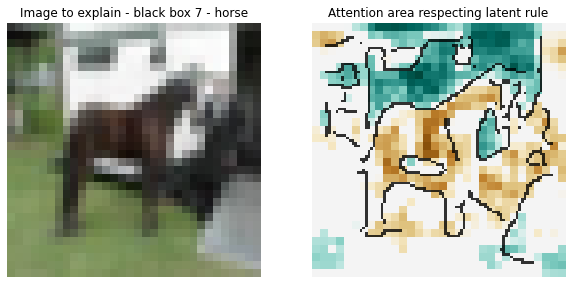

In [ ]:
img2show, mask = exp1.getFeaturesImportance(features=None, samples=1000)
use_rgb=True

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box {} - {}'.format(bbo, label_names[bbo]))
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

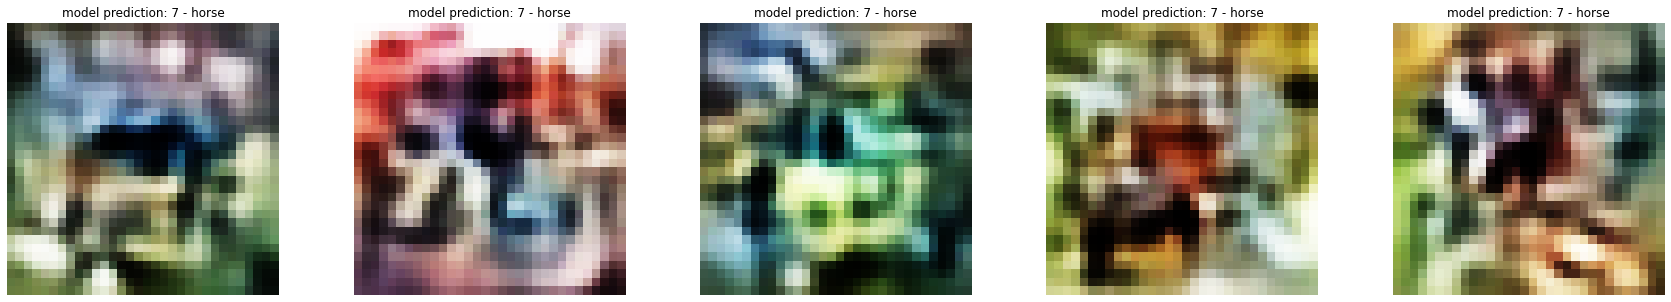

In [ ]:
proto = exp1.getExemplars(num_prototypes=5)

if len(proto)==1:
    bbo = bb_predict(proto[0][np.newaxis,:,:,:])[0]
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        bbo = bb_predict(proto[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

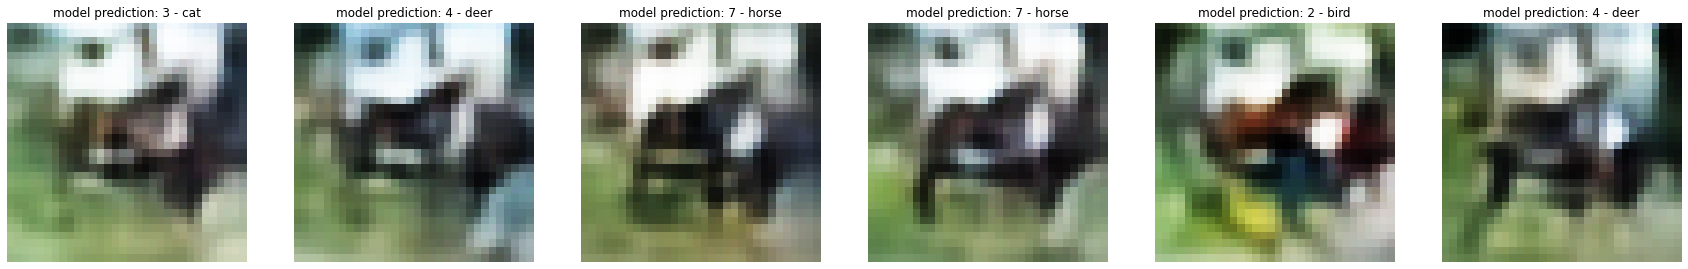

In [ ]:
counter = exp1.getCounterExemplars(eps=5, interp=0)

if len(counter)==1:
    bbo = bb_predict(counter[0][np.newaxis,:,:,:])[0]
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        bbo = bb_predict(counter[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

# Image 2

In [ ]:
# index Image 2 Explain
img = test_images[10]
# time
start = time.time()

# create explainer
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}

explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
exp2 = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp2.getRules(), exp2.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp2.exp.bb_pred,'dt prediction: ',exp2.exp.dt_pred,'fidelity: ',exp2.exp.fidelity)
print('latent space representation: ',exp2.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.523173	0.48312 	0.9888  
2  	78    	0.628263	0.466532	0.993305
3  	81    	0.784834	0.45829 	0.993305
4  	67    	0.900428	0.463397	0.993305
5  	78    	0.902165	0.474707	0.993305
6  	79    	0.887686	0.473887	0.993305
7  	72    	0.924044	0.48279 	0.993305
8  	72    	0.895878	0.479089	0.993305
9  	71    	0.904144	0.477421	0.993305
10 	72    	0.928487	0.48343 	0.993305
11 	57    	0.92058 	0.481999	0.993305
12 	68    	0.928448	0.480474	0.993305
13 	70    	0.915863	0.478823	0.993305
14 	74    	0.924074	0.485775	0.993305
15 	76    	0.912508	0.469091	0.993305
16 	80    	0.952173	0.485517	0.993305
17 	73    	0.924574	0.48309 	0.993305
18 	72    	0.928322	0.48509 	0.993305
19 	71    	0.939618	0.462009	0.993305
20 	73    	0.924181	0.48589 	0.993305
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.59626	0.484777	0.987815
2  	89    	0.814296	0.474087	0.992256
3  	81    	0.

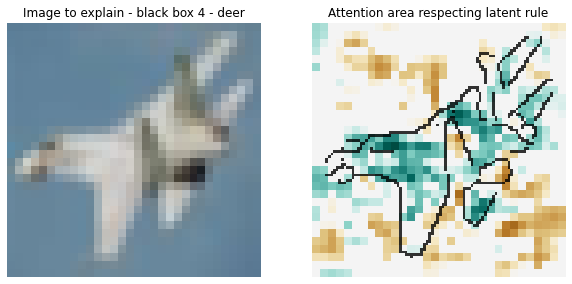

In [ ]:
img2show, mask = exp2.getFeaturesImportance(features=None, samples=1000)
use_rgb=True

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box {} - {}'.format(bbo, label_names[bbo]))
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

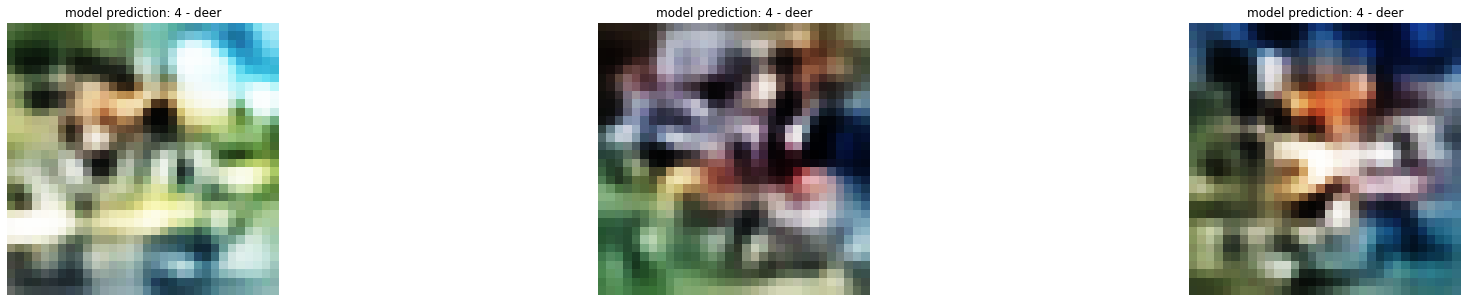

In [ ]:
proto = exp2.getExemplars(num_prototypes=5)

if len(proto)==1:
    bbo = bb_predict(proto[0][np.newaxis,:,:,:])[0]
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        bbo = bb_predict(proto[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

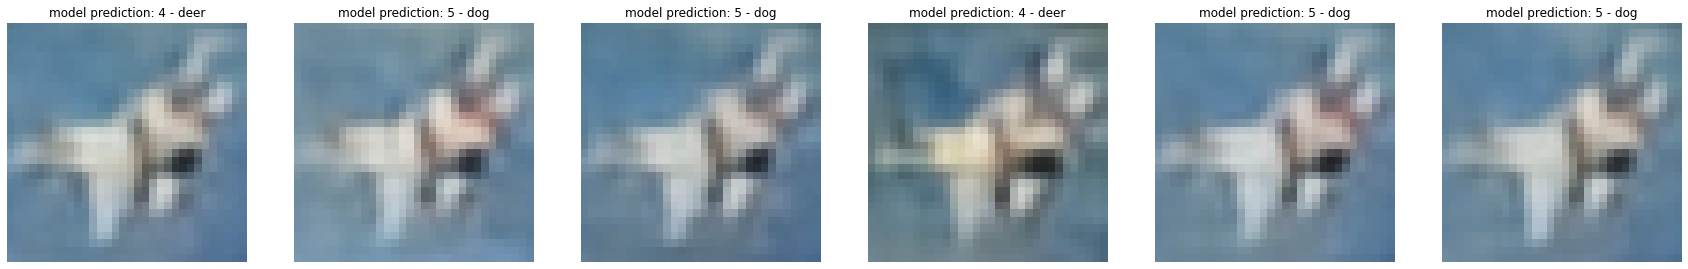

In [ ]:
counter = exp2.getCounterExemplars(eps=1, interp=0)

if len(counter)==1:
    bbo = bb_predict(counter[0][np.newaxis,:,:,:])[0]
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        bbo = bb_predict(counter[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

# Image 3

In [ ]:
# index Image 2 Explain
img = test_images[15]
# time
start = time.time()

# create explainer
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}

explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
exp3 = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp3.getRules(), exp3.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp3.exp.bb_pred,'dt prediction: ',exp3.exp.dt_pred,'fidelity: ',exp3.exp.fidelity)
print('latent space representation: ',exp3.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.535138	0.476649	0.990157
2  	78    	0.616679	0.465867	0.993263
3  	81    	0.78011 	0.444821	0.993263
4  	67    	0.912631	0.453462	0.993263
5  	78    	0.918223	0.475906	0.993263
6  	79    	0.943422	0.480197	0.993263
7  	72    	0.904484	0.485331	0.993263
8  	72    	0.931786	0.470274	0.993263
9  	71    	0.916347	0.484965	0.993263
10 	72    	0.96017 	0.486084	0.993263
11 	57    	0.940594	0.485919	0.993263
12 	68    	0.944343	0.477503	0.993263
13 	70    	0.927783	0.483912	0.993263
14 	74    	0.939887	0.488002	0.993263
15 	76    	0.932253	0.477224	0.993263
16 	80    	0.936393	0.47321 	0.993263
17 	73    	0.944482	0.48093 	0.993263
18 	72    	0.924347	0.48509 	0.993263
19 	71    	0.931775	0.476602	0.993263
20 	73    	0.936096	0.48634 	0.993263
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.561043	0.488723	0.988064
2  	89    	0.718163	0.449026	0.991471
3  	81    	0

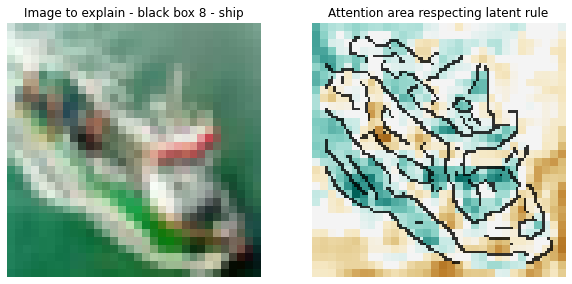

In [ ]:
img2show, mask = exp3.getFeaturesImportance(features=None, samples=1000)
use_rgb=True

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box {} - {}'.format(bbo, label_names[bbo]))
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

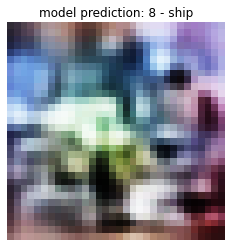

In [ ]:
proto = exp3.getExemplars(num_prototypes=5)

if len(proto)==1:
    bbo = bb_predict(proto[0][np.newaxis,:,:,:])[0]
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        bbo = bb_predict(proto[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

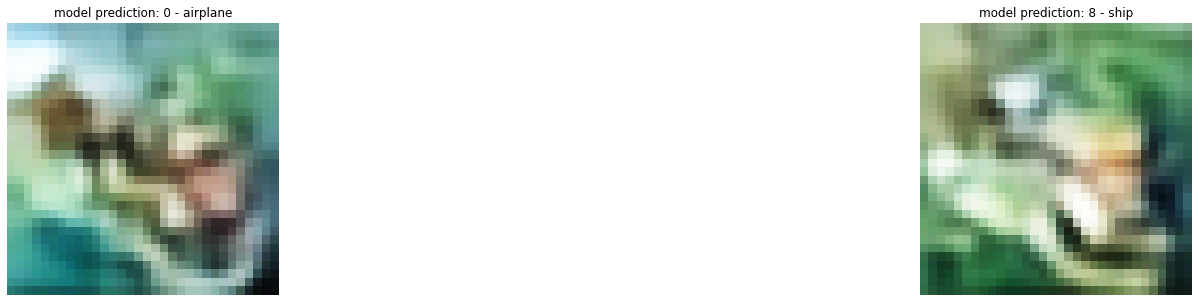

In [ ]:
counter = exp3.getCounterExemplars(eps=7, interp=0)

if len(counter)==1:
    bbo = bb_predict(counter[0][np.newaxis,:,:,:])[0]
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        bbo = bb_predict(counter[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

# Image 4

In [ ]:
# index Image 2 Explain
img = test_images[30]
# time
start = time.time()

# create explainer
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}

explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
exp4 = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp4.getRules(), exp4.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp4.exp.bb_pred,'dt prediction: ',exp4.exp.dt_pred,'fidelity: ',exp4.exp.fidelity)
print('latent space representation: ',exp4.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.5199  	0.48515 	0.98975 
2  	78    	0.562743	0.48522 	0.993191
3  	81    	0.684596	0.472353	0.993191
4  	67    	0.814092	0.461887	0.993191
5  	78    	0.866281	0.477862	0.993191
6  	79    	0.895325	0.477987	0.993191
7  	72    	0.904453	0.481641	0.993191
8  	72    	0.896959	0.486346	0.993191
9  	71    	0.897126	0.490161	0.993191
10 	72    	0.917142	0.490448	0.993191
11 	57    	0.91729 	0.492184	0.993191
12 	68    	0.936898	0.490873	0.993191
13 	70    	0.924711	0.488084	0.993191
14 	74    	0.89714 	0.487372	0.993191
15 	76    	0.916998	0.47913 	0.993191
16 	80    	0.913196	0.483065	0.993191
17 	73    	0.925156	0.490681	0.993191
18 	72    	0.905129	0.490817	0.993191
19 	71    	0.912892	0.487364	0.993191
20 	73    	0.901217	0.486799	0.993191
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.589521	0.493252	0.99025
2  	89    	0.818876	0.48629 	0.992578
3  	81    	0.

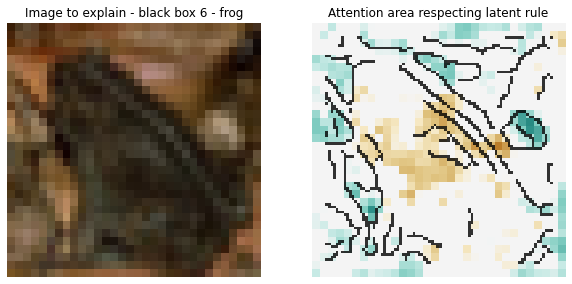

In [ ]:
img2show, mask = exp4.getFeaturesImportance(features=None, samples=1000)
use_rgb=True

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box {} - {}'.format(bbo, label_names[bbo]))
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

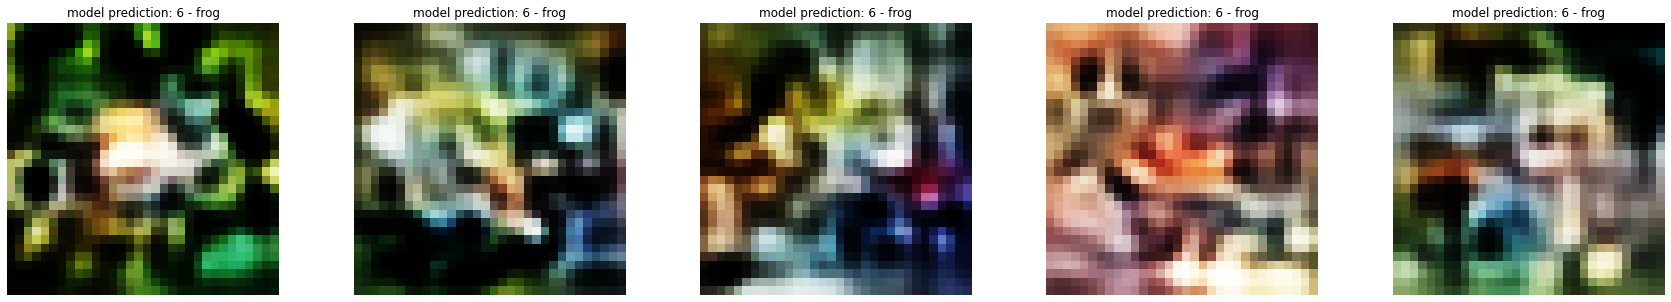

In [39]:
proto = exp4.getExemplars(num_prototypes=5)

if len(proto)==1:
    bbo = bb_predict(proto[0][np.newaxis,:,:,:])[0]
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        bbo = bb_predict(proto[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

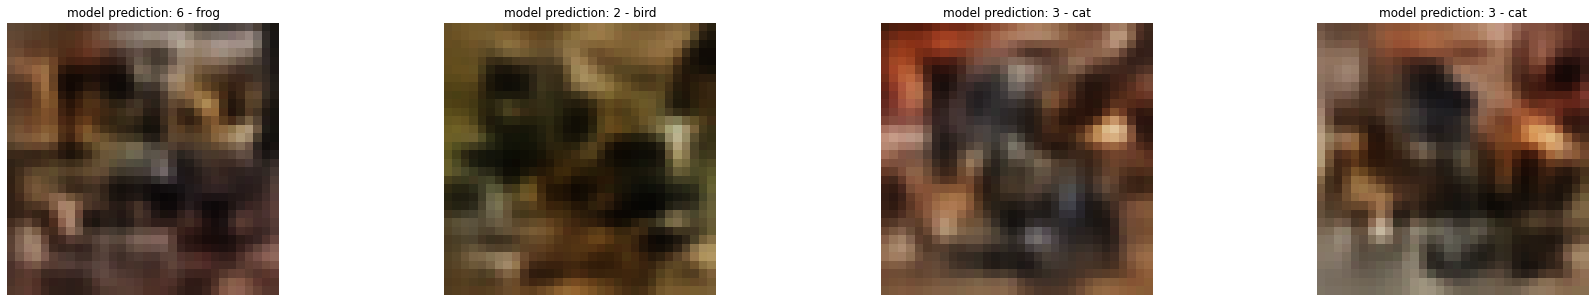

In [40]:
counter = exp4.getCounterExemplars(eps=5, interp=0)

if len(counter)==1:
    bbo = bb_predict(counter[0][np.newaxis,:,:,:])[0]
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        bbo = bb_predict(counter[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

# Image 5

In [41]:
# index Image 2 Explain
img = test_images[25]
# time
start = time.time()

# create explainer
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}

explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
exp5 = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp5.getRules(), exp5.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp5.exp.bb_pred,'dt prediction: ',exp5.exp.dt_pred,'fidelity: ',exp5.exp.fidelity)
print('latent space representation: ',exp5.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.499025	0.472737	0.976837
2  	78    	0.518567	0.476983	0.986369
3  	81    	0.560858	0.444698	0.987835
4  	67    	0.649559	0.455234	0.993112
5  	78    	0.733408	0.453668	0.993304
6  	79    	0.799309	0.445187	0.993112
7  	72    	0.840847	0.461513	0.993112
8  	72    	0.82697 	0.456457	0.993112
9  	71    	0.84569 	0.475043	0.993112
10 	72    	0.891441	0.479343	0.993112
11 	57    	0.908452	0.485387	0.993112
12 	68    	0.916117	0.465647	0.993112
13 	70    	0.876322	0.481484	0.993112
14 	74    	0.884238	0.477268	0.993112
15 	76    	0.900402	0.480895	0.993112
16 	80    	0.912409	0.463844	0.993112
17 	73    	0.90864 	0.484538	0.993112
18 	72    	0.884392	0.483341	0.993112
19 	71    	0.883833	0.466108	0.993112
20 	73    	0.888438	0.47673 	0.993112
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.608017	0.489944	0.987598
2  	89    	0.852863	0.451856	0.99308 
3  	81    	0

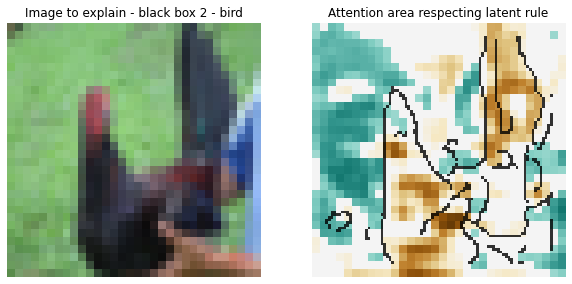

In [42]:
img2show, mask = exp5.getFeaturesImportance(features=None, samples=1000)
use_rgb=True

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box {} - {}'.format(bbo, label_names[bbo]))
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

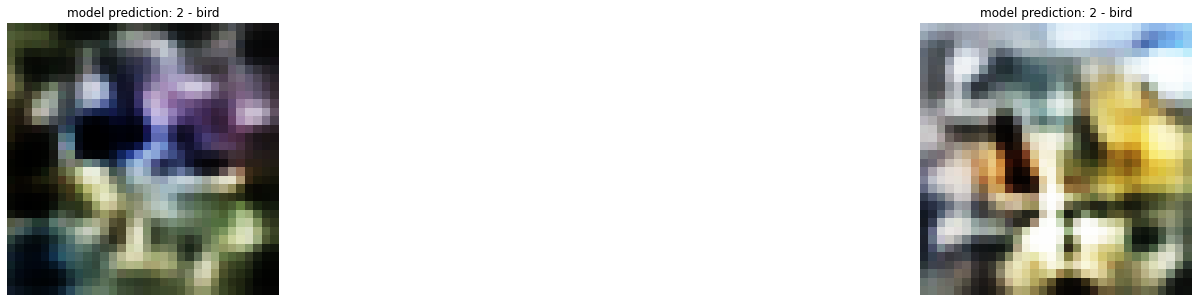

In [43]:
proto = exp5.getExemplars(num_prototypes=5)

if len(proto)==1:
    bbo = bb_predict(proto[0][np.newaxis,:,:,:])[0]
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        bbo = bb_predict(proto[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

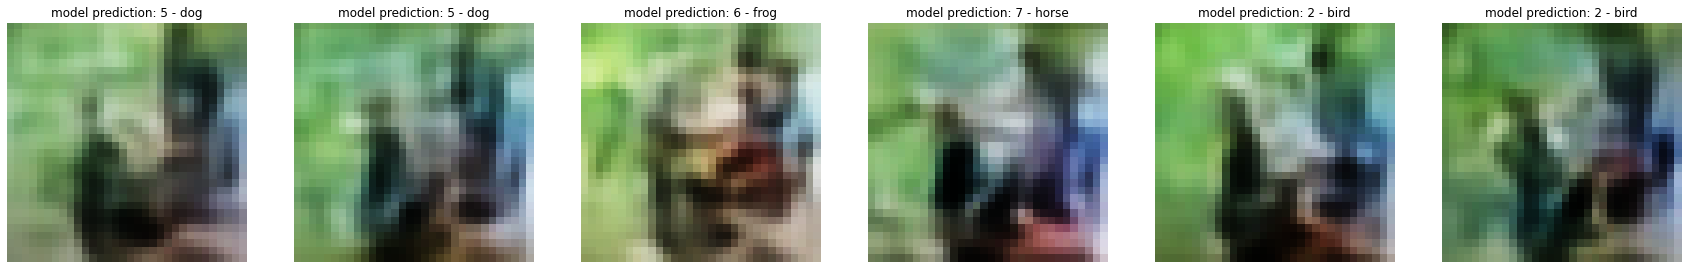

In [44]:
counter = exp5.getCounterExemplars(eps=5, interp=0)

if len(counter)==1:
    bbo = bb_predict(counter[0][np.newaxis,:,:,:])[0]
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        bbo = bb_predict(counter[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

# Image 6

In [45]:
# index Image 2 Explain
img = test_images[0]
# time
start = time.time()

# create explainer
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}

explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
exp6 = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp6.getRules(), exp6.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp6.exp.bb_pred,'dt prediction: ',exp6.exp.dt_pred,'fidelity: ',exp6.exp.fidelity)
print('latent space representation: ',exp6.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.526951	0.480813	0.987135
2  	78    	0.647332	0.469209	0.993205
3  	81    	0.783263	0.456888	0.993205
4  	67    	0.898947	0.460614	0.993215
5  	78    	0.90524 	0.468061	0.993215
6  	79    	0.939088	0.484469	0.993215
7  	72    	0.923745	0.466485	0.993295
8  	72    	0.911851	0.482149	0.993295
9  	71    	0.896305	0.480135	0.993295
10 	72    	0.948066	0.483824	0.993295
11 	57    	0.948357	0.479662	0.993295
12 	68    	0.948318	0.482897	0.993295
13 	70    	0.931784	0.481364	0.993295
14 	74    	0.912037	0.473926	0.993295
15 	76    	0.924159	0.468818	0.993295
16 	80    	0.948171	0.484591	0.993295
17 	73    	0.948334	0.486301	0.993295
18 	72    	0.932093	0.478017	0.993295
19 	71    	0.91597 	0.47339 	0.993295
20 	73    	0.924193	0.479189	0.993295
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.56088	0.479818	0.987486
2  	89    	0.7374 	0.482192	0.992685
3  	81    	0.9

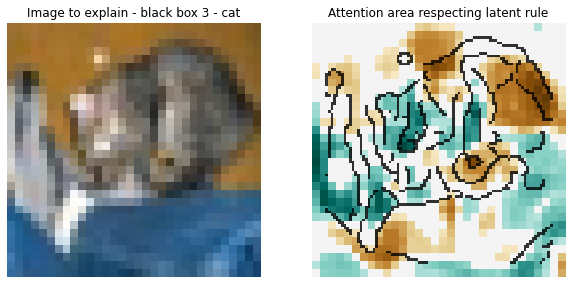

In [46]:
img2show, mask = exp6.getFeaturesImportance(features=None, samples=1000)
use_rgb=True

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box {} - {}'.format(bbo, label_names[bbo]))
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

In [47]:
proto = exp6.getExemplars(num_prototypes=5)

if len(proto)==1:
    bbo = bb_predict(proto[0][np.newaxis,:,:,:])[0]
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        bbo = bb_predict(proto[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

Exception: ignored

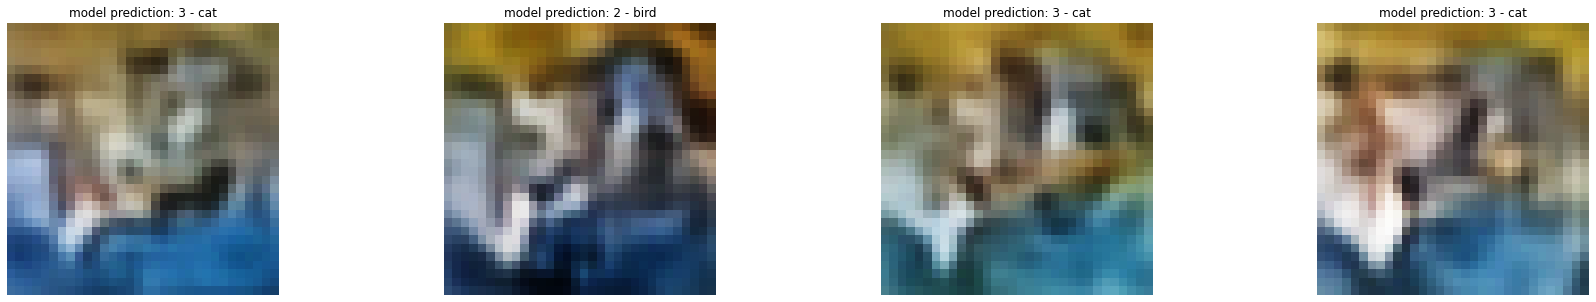

In [48]:
counter = exp6.getCounterExemplars(eps=5, interp=0)

if len(counter)==1:
    bbo = bb_predict(counter[0][np.newaxis,:,:,:])[0]
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        bbo = bb_predict(counter[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

#Image 7

In [51]:
# index Image 2 Explain
img = test_images[28]
# time
start = time.time()

# create explainer
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}

explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
exp7 = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp7.getRules(), exp7.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp7.exp.bb_pred,'dt prediction: ',exp7.exp.dt_pred,'fidelity: ',exp7.exp.fidelity)
print('latent space representation: ',exp7.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.500106	0.485936	0.987815
2  	78    	0.523522	0.486258	0.992957
3  	81    	0.618268	0.487714	0.993298
4  	67    	0.768181	0.483613	0.993298
5  	78    	0.834531	0.474682	0.993298
6  	79    	0.860215	0.479134	0.9933  
7  	72    	0.892741	0.476526	0.9933  
8  	72    	0.888944	0.487617	0.9933  
9  	71    	0.88922 	0.490583	0.9933  
10 	72    	0.925   	0.487149	0.9933  
11 	57    	0.929105	0.489124	0.9933  
12 	68    	0.917187	0.488607	0.9933  
13 	70    	0.885286	0.4868  	0.9933  
14 	74    	0.897164	0.4857  	0.9933  
15 	76    	0.909242	0.484229	0.9933  
16 	80    	0.925193	0.483512	0.9933  
17 	73    	0.921353	0.488177	0.9933  
18 	72    	0.897269	0.489438	0.9933  
19 	71    	0.905016	0.482384	0.9933  
20 	73    	0.897358	0.490859	0.9933  
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.597275	0.492241	0.990057
2  	89    	0.794726	0.481607	0.991784
3  	81    	0

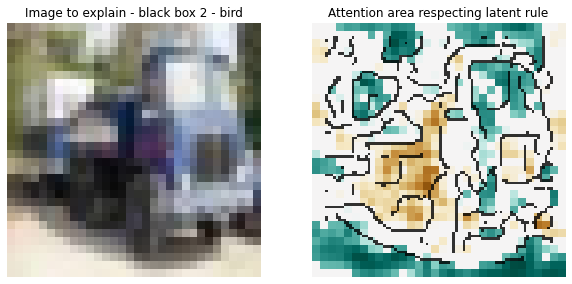

In [52]:
img2show, mask = exp7.getFeaturesImportance(features=None, samples=1000)
use_rgb=True

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box {} - {}'.format(bbo, label_names[bbo]))
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

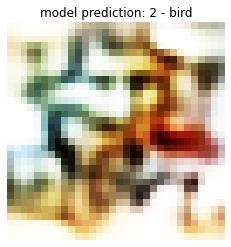

In [53]:
proto = exp7.getExemplars(num_prototypes=5)

if len(proto)==1:
    bbo = bb_predict(proto[0][np.newaxis,:,:,:])[0]
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        bbo = bb_predict(proto[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

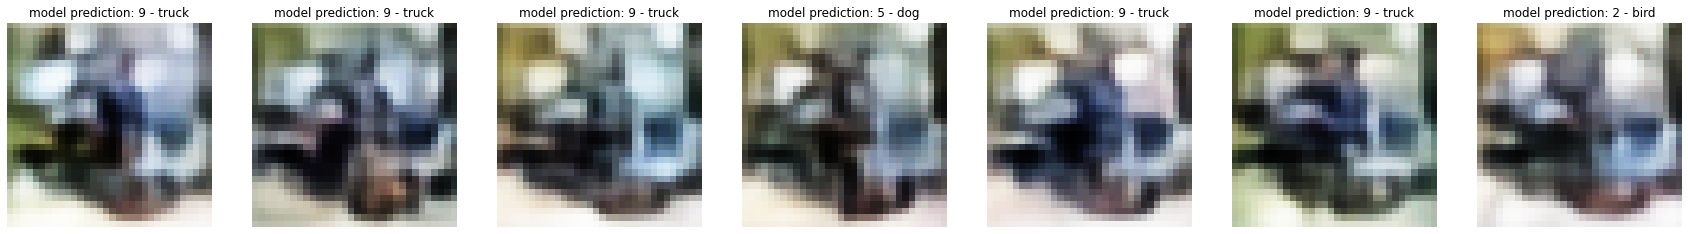

In [54]:
counter = exp7.getCounterExemplars(eps=5, interp=0)

if len(counter)==1:
    bbo = bb_predict(counter[0][np.newaxis,:,:,:])[0]
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        bbo = bb_predict(counter[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

#Image 8

In [55]:
# index Image 2 Explain
img = test_images[35]
# time
start = time.time()

# create explainer
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}

explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
exp8 = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp8.getRules(), exp8.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp8.exp.bb_pred,'dt prediction: ',exp8.exp.dt_pred,'fidelity: ',exp8.exp.fidelity)
print('latent space representation: ',exp8.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.519915	0.488263	0.988499
2  	78    	0.60226 	0.476449	0.993063
3  	81    	0.739457	0.474232	0.993063
4  	67    	0.861825	0.472503	0.993063
5  	78    	0.898534	0.481506	0.993063
6  	79    	0.883991	0.479742	0.993063
7  	72    	0.896494	0.484749	0.993063
8  	72    	0.900366	0.486922	0.993082
9  	71    	0.884911	0.481085	0.993256
10 	72    	0.920898	0.489516	0.993289
11 	57    	0.928942	0.489782	0.993289
12 	68    	0.928864	0.491939	0.993289
13 	70    	0.885082	0.488946	0.993289
14 	74    	0.900922	0.485858	0.993289
15 	76    	0.917019	0.483028	0.993289
16 	80    	0.929065	0.485905	0.993289
17 	73    	0.929189	0.490527	0.993289
18 	72    	0.901206	0.484064	0.993289
19 	71    	0.912944	0.481024	0.993289
20 	73    	0.93681 	0.489552	0.993289
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.585564	0.494305	0.990624
2  	89    	0.786962	0.478109	0.992152
3  	81    	0

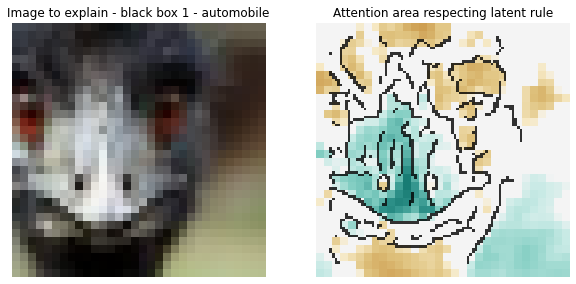

In [56]:
img2show, mask = exp8.getFeaturesImportance(features=None, samples=1000)
use_rgb=True

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box {} - {}'.format(bbo, label_names[bbo]))
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

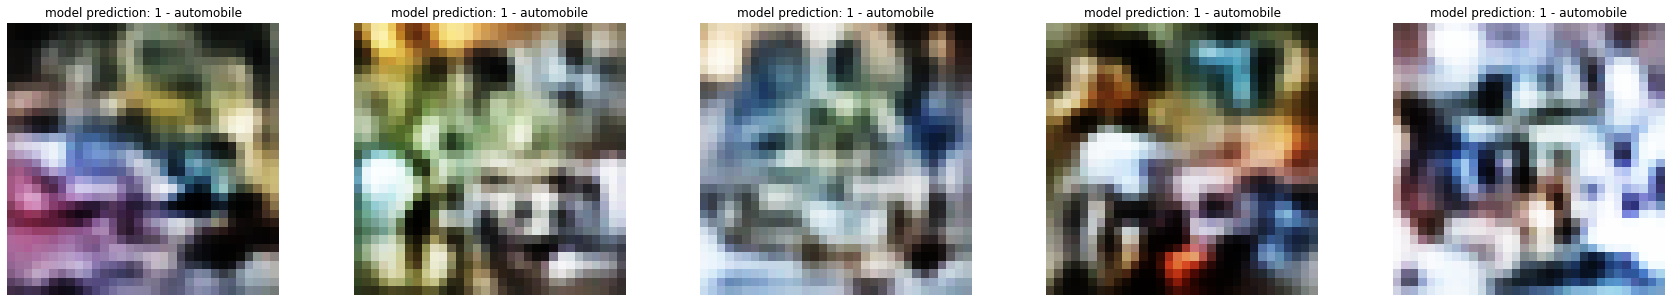

In [57]:
proto = exp8.getExemplars(num_prototypes=5)

if len(proto)==1:
    bbo = bb_predict(proto[0][np.newaxis,:,:,:])[0]
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        bbo = bb_predict(proto[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

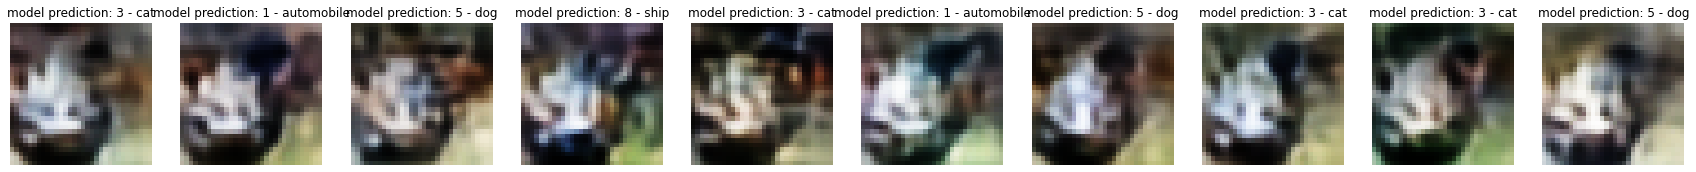

In [58]:
counter = exp8.getCounterExemplars(eps=5, interp=0)

if len(counter)==1:
    bbo = bb_predict(counter[0][np.newaxis,:,:,:])[0]
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        bbo = bb_predict(counter[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

#Image 9

In [1]:
# index Image 2 Explain
img = test_images[9836]
# time
start = time.time()

# create explainer
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}

explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
exp9 = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp9.getRules(), exp9.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp9.exp.bb_pred,'dt prediction: ',exp9.exp.dt_pred,'fidelity: ',exp9.exp.fidelity)
print('latent space representation: ',exp9.exp.limg)

NameError: ignored

In [ ]:
img2show, mask = exp9.getFeaturesImportance(features=None, samples=1000)
use_rgb=True

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box {} - {}'.format(bbo, label_names[bbo]))
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

In [ ]:
proto = exp9.getExemplars(num_prototypes=5)

if len(proto)==1:
    bbo = bb_predict(proto[0][np.newaxis,:,:,:])[0]
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        bbo = bb_predict(proto[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

In [ ]:
counter = exp9.getCounterExemplars(eps=5, interp=0)

if len(counter)==1:
    bbo = bb_predict(counter[0][np.newaxis,:,:,:])[0]
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        bbo = bb_predict(counter[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

#Image 10

In [ ]:
# index Image 2 Explain
img = test_images[45]
# time
start = time.time()

# create explainer
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}

explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
exp10 = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp10.getRules(), exp10.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp10.exp.bb_pred,'dt prediction: ',exp10.exp.dt_pred,'fidelity: ',exp10.exp.fidelity)
print('latent space representation: ',exp10.exp.limg)

In [ ]:
img2show, mask = exp10.getFeaturesImportance(features=None, samples=1000)
use_rgb=True

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box {} - {}'.format(bbo, label_names[bbo]))
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

In [ ]:
proto = exp10.getExemplars(num_prototypes=5)

if len(proto)==1:
    bbo = bb_predict(proto[0][np.newaxis,:,:,:])[0]
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        bbo = bb_predict(proto[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')

In [ ]:
counter = exp10.getCounterExemplars(eps=5, interp=0)

if len(counter)==1:
    bbo = bb_predict(counter[0][np.newaxis,:,:,:])[0]
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        bbo = bb_predict(counter[i][np.newaxis,:,:,:])[0]
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: {} - {}'.format(bbo, label_names[bbo]))
        ax[i].axis('off')